# Clustering U.S. Senators

In the United States (U.S.), the Senate votes on proposed legislation. In order to get a provision enacted, the Senate must get the bill passed. A bill requires a majority vote to pass. The results of these votes, known as roll call votes, are public, and available in a few places, including [here](https://github.com/unitedstates/congress). Read more about the US legislative system [here](https://en.wikipedia.org/wiki/Federal_government_of_the_United_States#Legislative_branch).

`114_congress.csv` contains all of the results of roll call **votes from the 114th Senate**. Each row represents a single Senator and each column represents a vote. A `0` in a cell means the Senator voted No on the bill, `1` means the Senator voted Yes, and `0.5` means the Senator abstained.

The columns have the following information:
 - name - The Senator's last name
 - party - Which party does the Senator belong to
 - state - Which U.S. State the Senator represents
 - 000\#\# - Each of these columns represents the results of a single roll call vote.

Clustering Senators' voting data is particularly interesting, because it can expose patterns that go deeper than party affiliation. For example, some Republicans are more liberal than others. Looking at voting data can help us discover the Senators who are more or less in the mainstream of their party.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

votes = pd.read_csv('114_congress.csv')

In [2]:
print('DataFrame Shape: ', votes.shape)
votes.head()

DataFrame Shape:  (100, 18)


,name,party,state,00001,00004,00005,00006,00007,00008,00009,00010,00020,00026,00032,00038,00039,00044,00047
0,Alexander,R,TN,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Ayotte,R,NH,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,Baldwin,D,WI,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
3,Barrasso,R,WY,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,Bennet,D,CO,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [3]:
votes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    100 non-null    object 
 1   party   100 non-null    object 
 2   state   100 non-null    object 
 3   00001   100 non-null    float64
 4   00004   100 non-null    float64
 5   00005   100 non-null    float64
 6   00006   100 non-null    float64
 7   00007   100 non-null    float64
 8   00008   100 non-null    float64
 9   00009   100 non-null    float64
 10  00010   100 non-null    float64
 11  00020   100 non-null    float64
 12  00026   100 non-null    float64
 13  00032   100 non-null    float64
 14  00038   100 non-null    float64
 15  00039   100 non-null    float64
 16  00044   100 non-null    float64
 17  00047   100 non-null    float64
dtypes: float64(15), object(3)
memory usage: 14.2+ KB


In [4]:
# find out how many Senators are in each party
print(votes["party"].value_counts())
print('\n')
# the average vote for each bill
print('Bill:    Vote (%):')
print(votes.mean()*100)

R    54
D    44
I     2
Name: party, dtype: int64


Bill:    Vote (%):
00001    32.5
00004    57.5
00005    53.5
00006    94.5
00007    54.5
00008    41.5
00009    54.5
00010    98.5
00020    52.5
00026    54.5
00032    41.0
00038    48.0
00039    51.0
00044    46.0
00047    37.0
dtype: float64


/var/folders/x_/9mvkqqv57d7_mn3fvzr8w4v40000gn/T/ipykernel_1763/4062084396.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(votes.mean()*100)


## Distance Between Senators

We can mathematically find how "close" the Senators are to each other using [Euclidean Distance](https://en.wikipedia.org/wiki/Euclid). Essentially, the closer the voting record of two Senators, the more similar they are.

In [5]:
# an example
distance = euclidean_distances(votes.iloc[0,3:].values.reshape(1, -1),
                               votes.iloc[2,3:].values.reshape(1, -1))
print(distance)

[[3.31662479]]


**K-Means Clustering** is an algorithm that uses Euclidean Distance to form clusters of similar Senators. The k-means algorithm requires us to specify the number of clusters *upfront*. Because we suspect that clusters will occur along party lines and the vast majority of Senators are either Republicans or Democrats, we'll pick `2` for our number of clusters.

We'll then be able to use the `fit_transform()` method to fit the model to `votes` and get the distance of each Senator to each cluster.

In [6]:
kmeans_model = KMeans(n_clusters=2, random_state=1)
senator_distances = kmeans_model.fit_transform(votes.iloc[:,3:])

We can use the Pandas method `crosstab()` to compute and display how many Senators from each party ended up in each cluster.

In [7]:
# extract the labels from the kmeans_model
labels = kmeans_model.labels_
# print a table comparing the votes to the Party
pd.crosstab(labels, votes['party'])

party,D,I,R
row_0,,,
0,41,2,0
1,3,0,54


It looks like both of our clusters mostly broke down along party lines. The first cluster contains 41 Democrats and two Independents. The second cluster contains 3 Democrats, and 54 Republicans.

No Republicans seem to have broken party ranks to vote with the Democrats, but 3 vote similar to Republicans in their voting than their own party. Let's explore these 3 in more depth so we can figure out why that is.

In [8]:
# select Senators in the second cluster that were Democrats
democratic_outliers = votes[(labels == 1) & (votes['party'] == 'D')]
democratic_outliers

,name,party,state,00001,00004,00005,00006,00007,00008,00009,00010,00020,00026,00032,00038,00039,00044,00047
42,Heitkamp,D,ND,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
56,Manchin,D,WV,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
74,Reid,D,NV,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


## Plotting the clusters

Let's visualize the `senator_distances` array that we computed earlier. We will treat these distances as `x` and `y` coordinates because the distances are relative to the cluster centers.

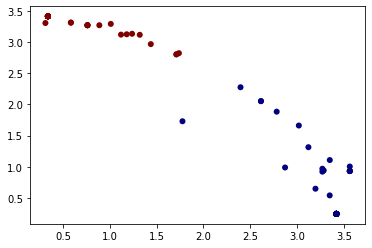

In [9]:
x = senator_distances[:,0]
y = senator_distances[:,1]

plt.scatter(x, y, c=labels, linewidths=0, cmap='jet_r')
plt.show()

The most extreme Senators are those who are the furthest away from one cluster. For example, a radical Republican would be as far from the Democratic cluster as possible. Senators who are in between both clusters are more moderate, as they fall between the views of the two parties.

We'll create a formula to find extremists -- we'll cube the distances in both columns of `senator_distances`, then add them together. We cube the distances so that we can get a good amount of separation between the extremists who are farthest from a party.

In [10]:
# compute an extremism rating
extremism = (senator_distances**3).sum(axis=1)
# new column for extremists
votes['extremism'] = extremism
# sort top-down
votes.sort_values('extremism', inplace=True, ascending=False)
votes.head(10)

,name,party,state,00001,00004,00005,00006,00007,00008,00009,00010,00020,00026,00032,00038,00039,00044,00047,extremism
98,Wicker,R,MS,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,46.250476
53,Lankford,R,OK,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,46.046873
69,Paul,R,KY,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,46.046873
80,Sasse,R,NE,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,46.046873
26,Cruz,R,TX,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,46.046873
48,Johnson,R,WI,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,40.017540
47,Isakson,R,GA,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,40.017540
65,Murkowski,R,AK,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,40.017540
64,Moran,R,KS,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,40.017540
30,Enzi,R,WY,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,40.017540


# Conclusion

Clustering is a powerful way to explore data and find patterns. Unsupervised learning is good to use for large datasets where it isn't obvious where to start. In general, it's a good idea to try unsupervised learning to explore a dataset before trying to use supervised learning machine learning models.

The biggest issue that comes up with most cluster analysis methods is that while they’re great at initially separating your data into subsets, the strategies used are sometimes not necessarily related to the data itself, but to its positioning in relation to other points.

Another type of clustering, Hierarchical clustering, tends to produce more accurate results, but it requires significant computational power and is not ideal when you’re working with larger datasets. This method is also sensitive to outlier values and can produce an inaccurate set of clusters as a result. 

Therefore, you should deploy clustering where and when it will give you the greatest impact and insights. Clustering can not only give you a great starting point but shed light on important features of your data that can be enhanced with deeper analytics. 